In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 4
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 257
vmax = 980
vmin = 800
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

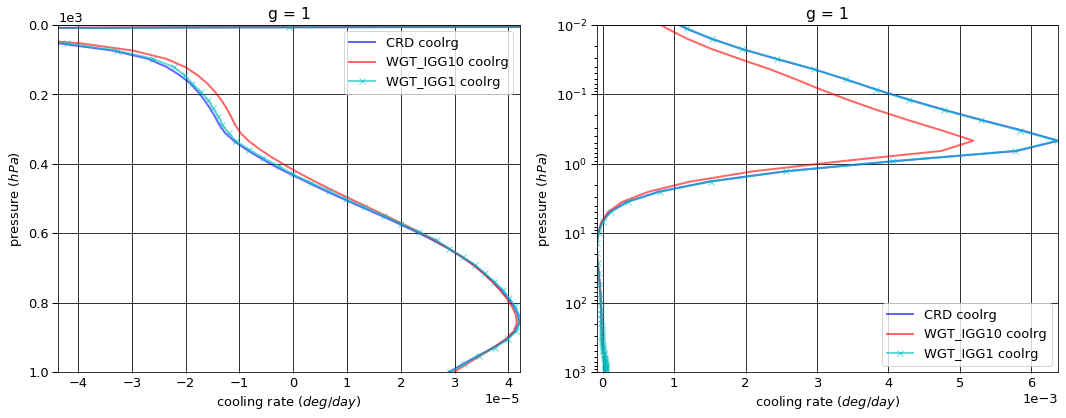

# Figure: cooling rate g-group 2

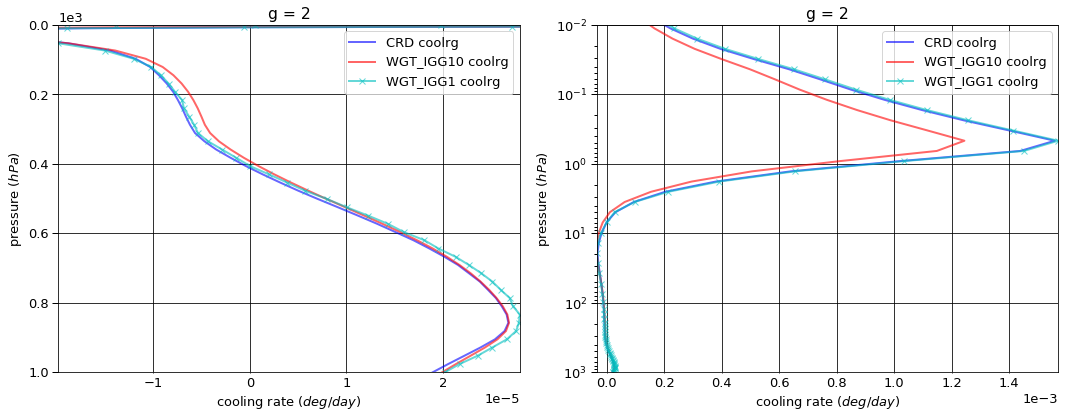

# Figure: cooling rate g-group 3

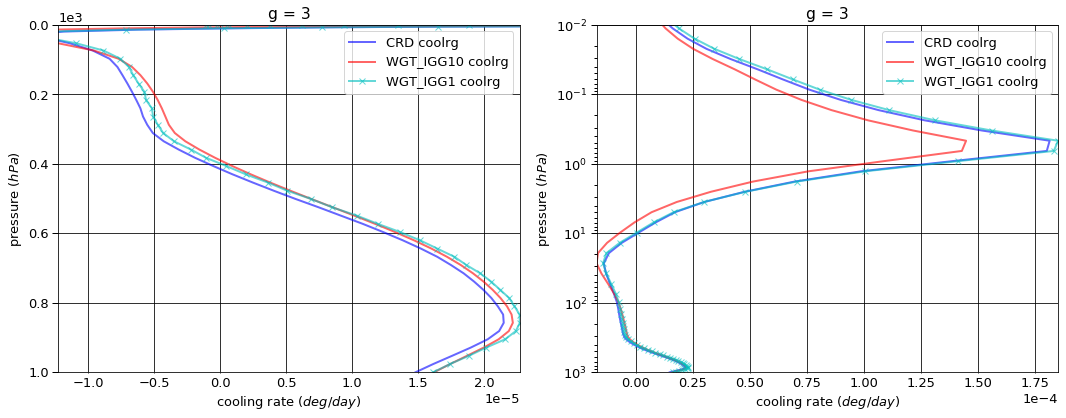

# Figure: cooling rate g-group 4

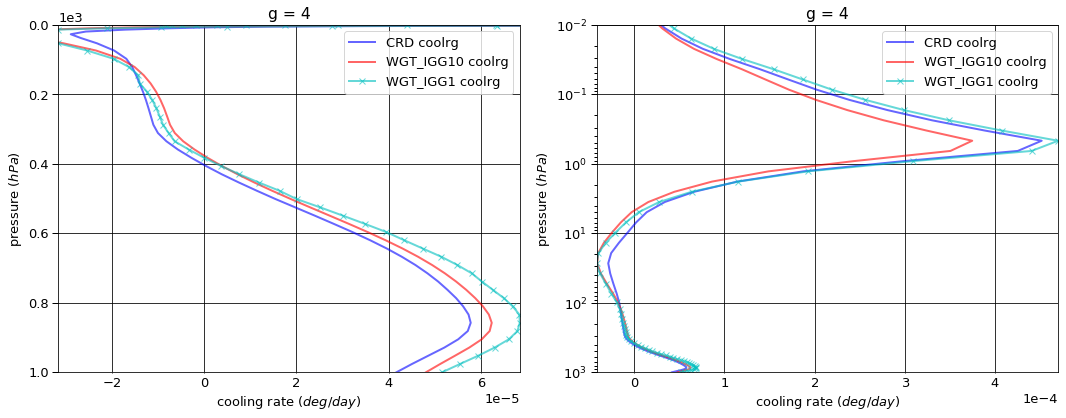

# Figure: cooling rate g-group 5

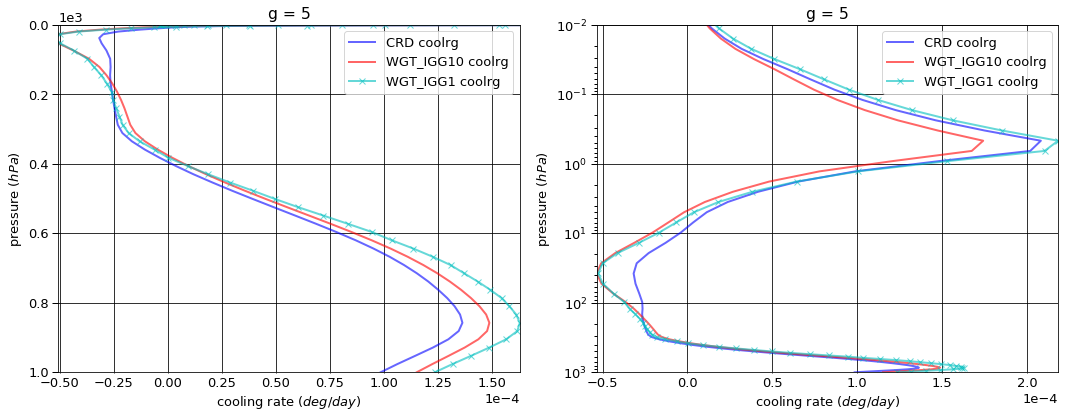

# Figure: cooling rate g-group 6

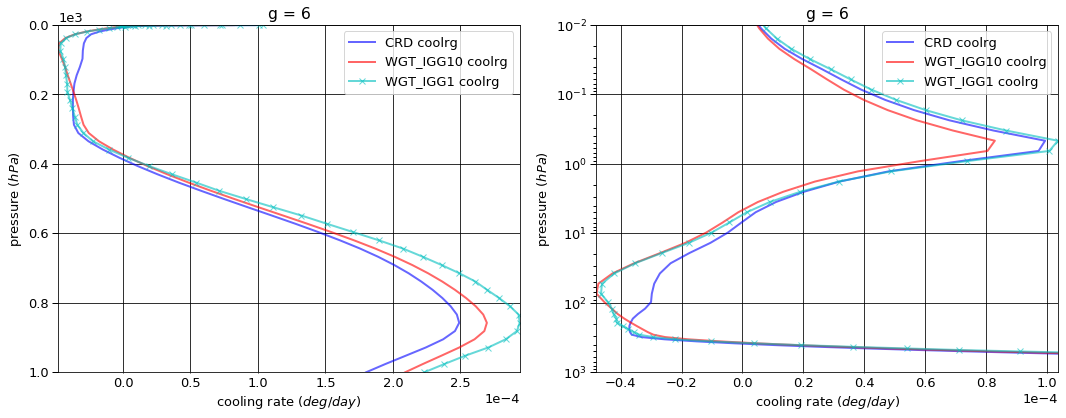

# Figure: cooling rate g-group 7

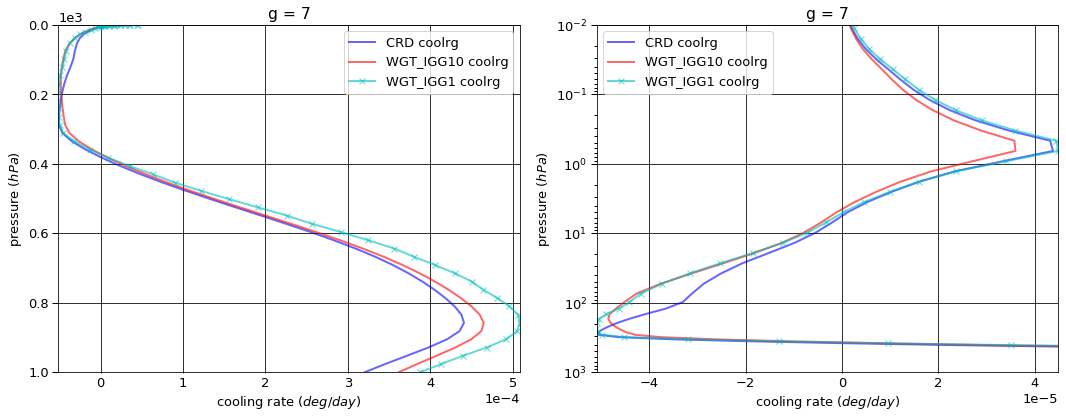

# Figure: cooling rate g-group 8

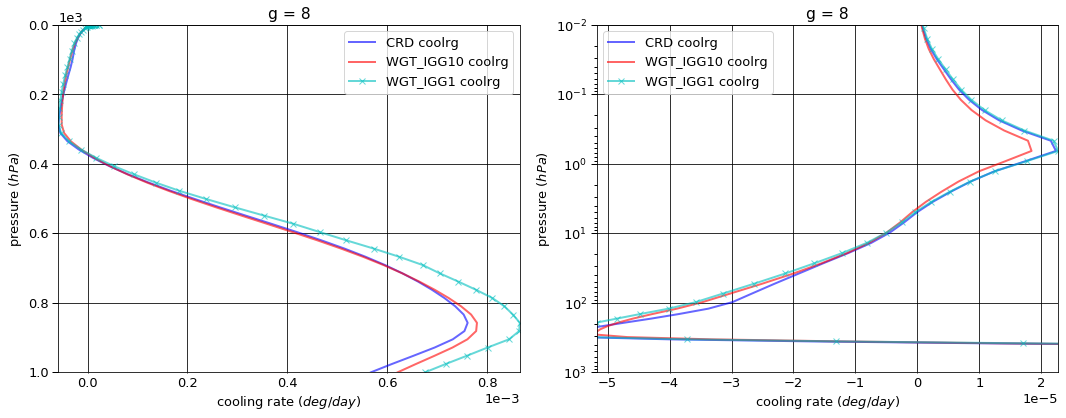

# Figure: cooling rate g-group 9

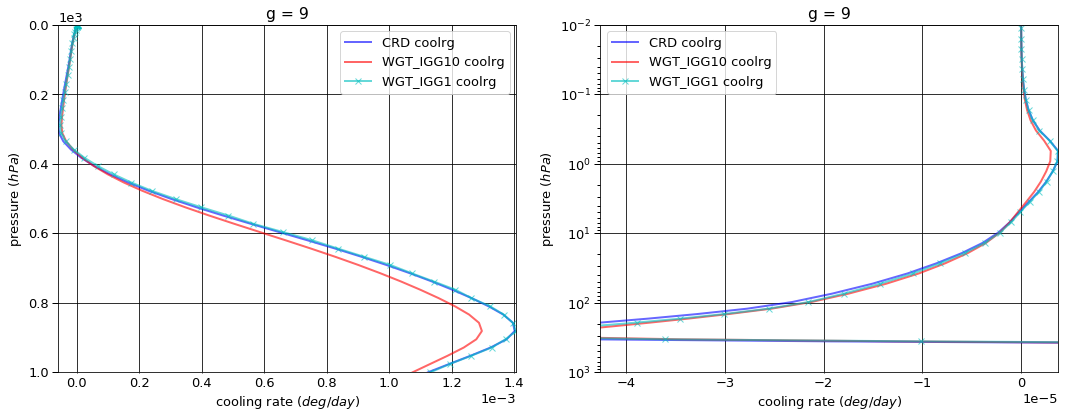

# Figure: cooling rate g-group 10

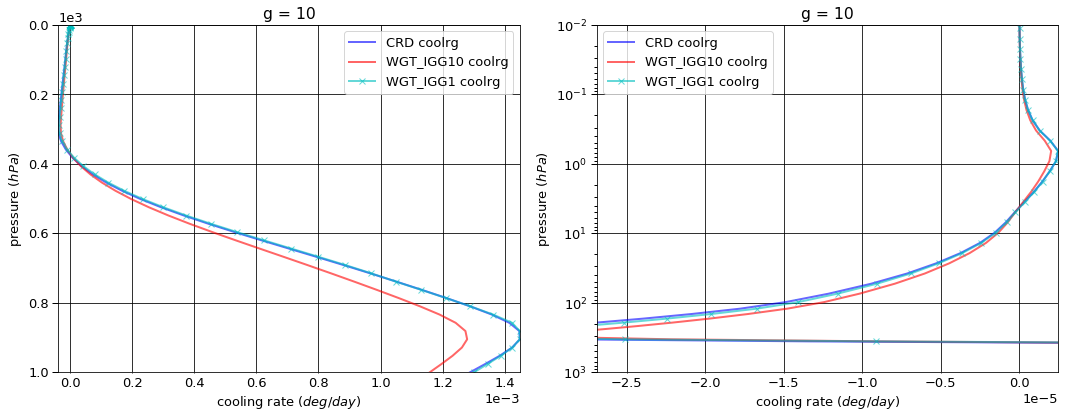

# Figure: cooling rate g-group 11

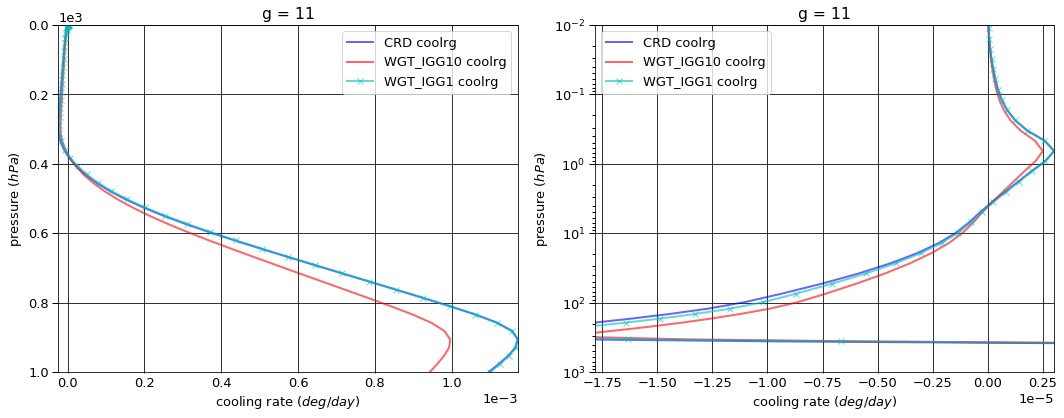

# Figure: cooling rate g-group 12

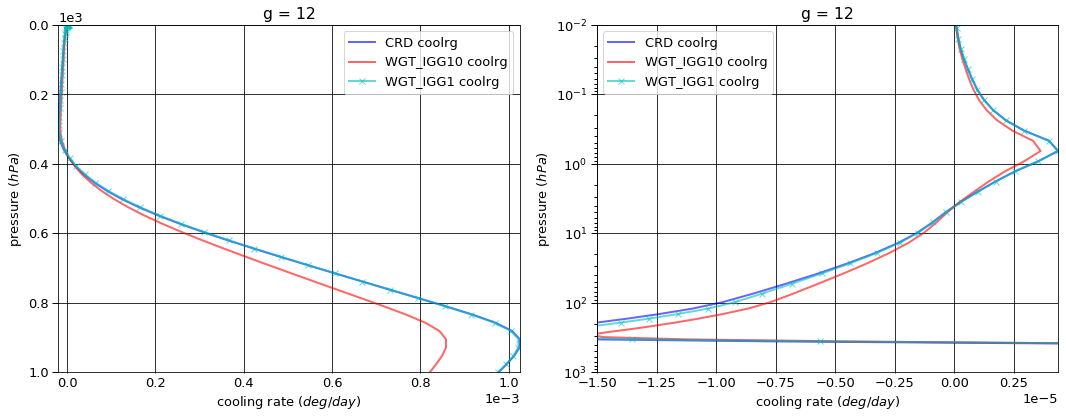

# Figure: cooling rate g-group 13

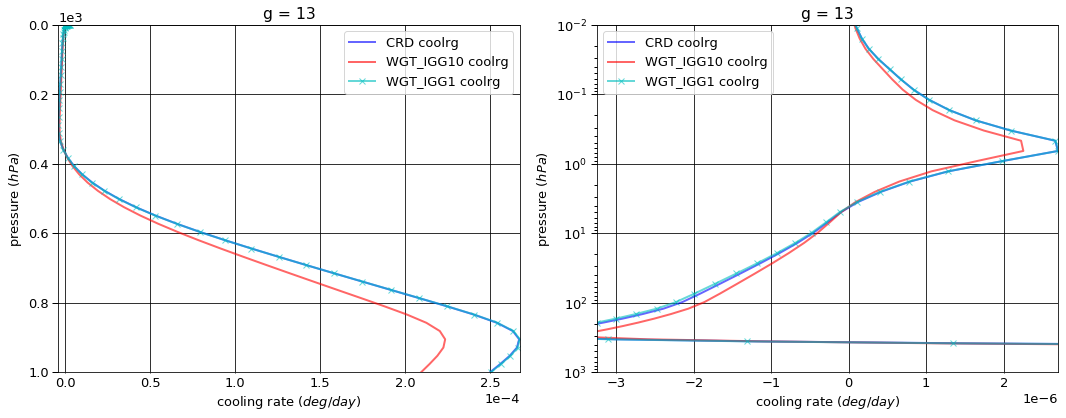

# Figure: cooling rate g-group 14

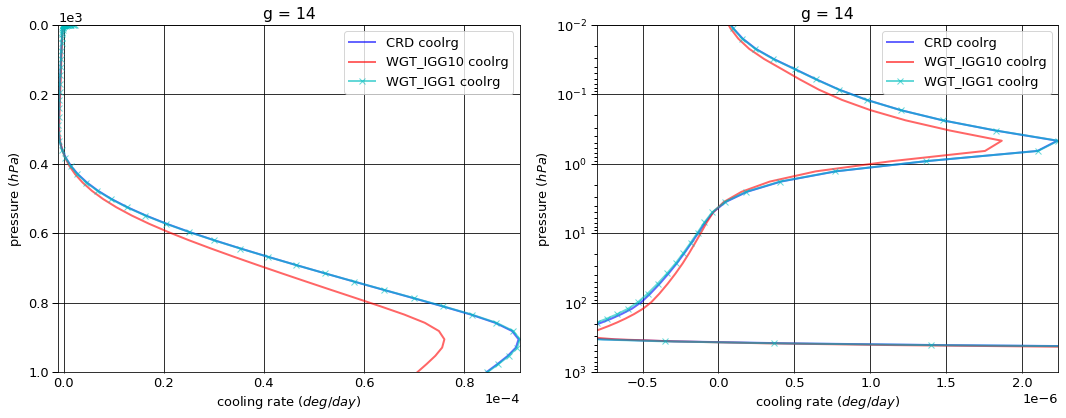

# Figure: cooling rate g-group 15

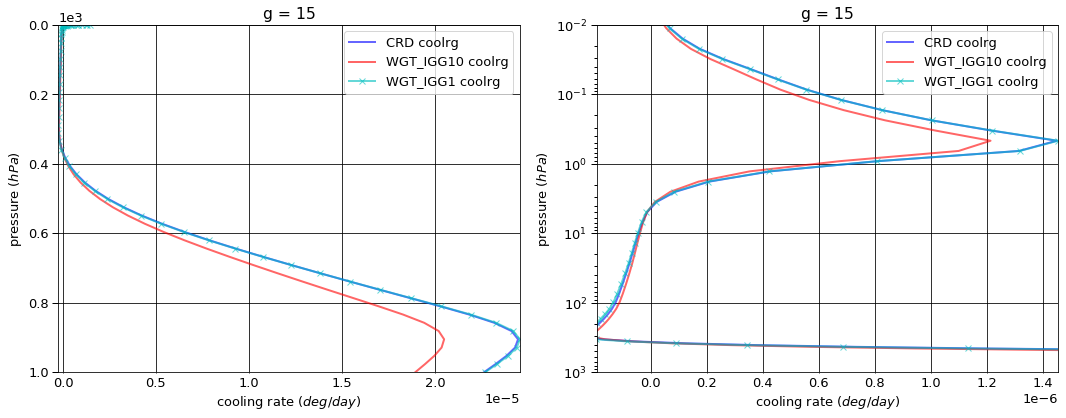

# Figure: cooling rate g-group 16

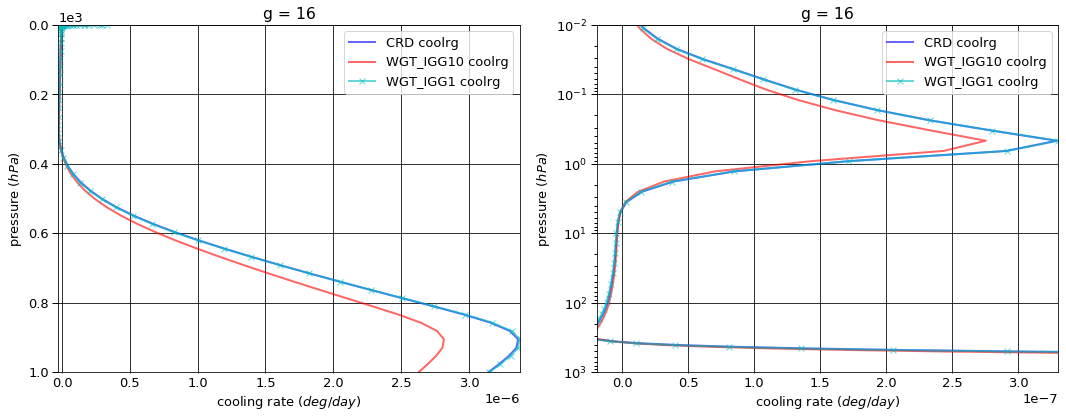

# Figure: cooling rate g-group total

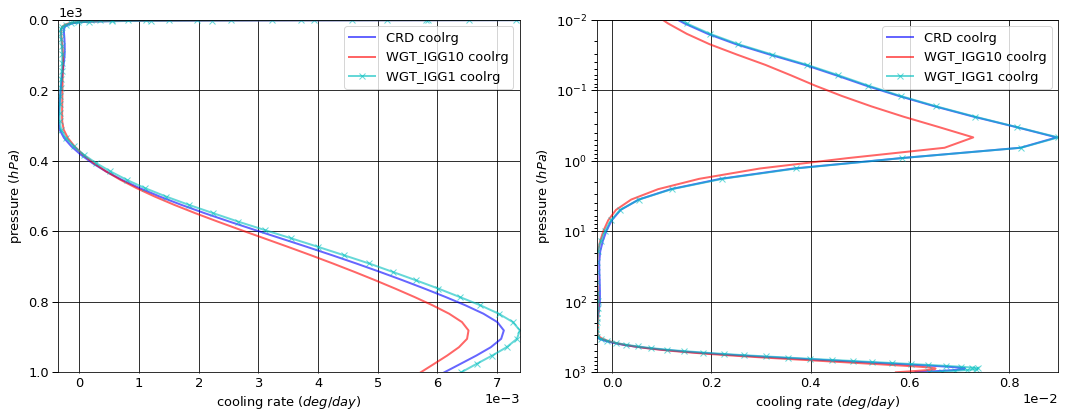

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010509  0.000000 -0.010509
   1013.0   76    -0.013172  0.004555 -0.008616
2  0.0      1     -0.010458  0.000000 -0.010458
   1013.0   76    -0.011930  0.002555 -0.009375
3  0.0      1     -0.006392  0.000000 -0.006392
   1013.0   76    -0.007519  0.001890 -0.005629
4  0.0      1     -0.050166  0.000000 -0.050166
   1013.0   76    -0.052595  0.004650 -0.047945
5  0.0      1     -0.101457  0.000000 -0.101457
   1013.0   76    -0.106330  0.010505 -0.095824
6  0.0      1     -0.171483  0.000000 -0.171483
   1013.0   76    -0.178783  0.018208 -0.160576
7  0.0      1     -0.296318  0.000000 -0.296318
   1013.0   76    -0.306512  0.030228 -0.276284
8  0.0      1     -0.562088  0.000000 -0.562088
   1013.0   76    -0.574565  0.047719 -0.526846
9  0.0      1     -0.541863  0.000000 -0.541863
   1013.0   76    -0.555745  0.076651 -0.479094
10 0.0      1     -1.222589  0.000000 -1.222589
   1013.0   76    -1.231843  0.070254 -1.161589
11 0.0      1     -2.783140  0.000000 -2.783140
   1013.0   76    -2.789121  0.053192 -2.735929
12 0.0      1     -7.237634  0.000000 -7.237634
   1013.0   76    -7.242588  0.045732 -7.196856
13 0.0      1     -6.047351  0.000000 -6.047351
   1013.0   76    -6.048521  0.011785 -6.036736
14 0.0      1     -6.375075  0.000000 -6.375075
   1013.0   76    -6.375403  0.003880 -6.371523
15 0.0      1     -5.398453  0.000000 -5.398453
   1013.0   76    -5.398534  0.001030 -5.397504
16 0.0      1     -1.970596  0.000000 -1.970596
   1013.0   76    -1.970605  0.000137 -1.970468


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010505  0.000000 -0.010505
   1013.0   76    -0.013149  0.004532 -0.008617
2  0.0      1     -0.010446  0.000000 -0.010446
   1013.0   76    -0.011879  0.002534 -0.009345
3  0.0      1     -0.006406  0.000000 -0.006406
   1013.0   76    -0.007479  0.001927 -0.005552
4  0.0      1     -0.050161  0.000000 -0.050161
   1013.0   76    -0.052512  0.004862 -0.047650
5  0.0      1     -0.101569  0.000000 -0.101569
   1013.0   76    -0.106319  0.010998 -0.095321
6  0.0      1     -0.171735  0.000000 -0.171735
   1013.0   76    -0.178660  0.018837 -0.159823
7  0.0      1     -0.296647  0.000000 -0.296647
   1013.0   76    -0.305971  0.030528 -0.275443
8  0.0      1     -0.563180  0.000000 -0.563180
   1013.0   76    -0.574203  0.046927 -0.527275
9  0.0      1     -0.541711  0.000000 -0.541711
   1013.0   76    -0.553453  0.069712 -0.483741
10 0.0      1     -1.220224  0.000000 -1.220224
   1013.0   76    -1.227886  0.061288 -1.166597
11 0.0      1     -2.774326  0.000000 -2.774326
   1013.0   76    -2.779224  0.045081 -2.734142
12 0.0      1     -7.221509  0.000000 -7.221509
   1013.0   76    -7.225566  0.038314 -7.187252
13 0.0      1     -6.051940  0.000000 -6.051940
   1013.0   76    -6.052920  0.009851 -6.043070
14 0.0      1     -6.386838  0.000000 -6.386838
   1013.0   76    -6.387114  0.003242 -6.383873
15 0.0      1     -5.411931  0.000000 -5.411931
   1013.0   76    -5.412000  0.000861 -5.411139
16 0.0      1     -1.975424  0.000000 -1.975424
   1013.0   76    -1.975432  0.000115 -1.975317


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.010499  0.000000 -0.010499
   1013.0   76    -0.013149  0.004621 -0.008528
2  0.0      1     -0.010358  0.000000 -0.010358
   1013.0   76    -0.011879  0.002686 -0.009193
3  0.0      1     -0.006342  0.000000 -0.006342
   1013.0   76    -0.007479  0.002021 -0.005459
4  0.0      1     -0.049848  0.000000 -0.049848
   1013.0   76    -0.052512  0.005437 -0.047075
5  0.0      1     -0.100933  0.000000 -0.100933
   1013.0   76    -0.106319  0.012247 -0.094072
6  0.0      1     -0.170769  0.000000 -0.170769
   1013.0   76    -0.178660  0.020976 -0.157684
7  0.0      1     -0.295267  0.000000 -0.295267
   1013.0   76    -0.305971  0.034119 -0.271852
8  0.0      1     -0.561387  0.000000 -0.561387
   1013.0   76    -0.574203  0.052977 -0.521226
9  0.0      1     -0.539848  0.000000 -0.539848
   1013.0   76    -0.553453  0.077122 -0.476331
10 0.0      1     -1.218790  0.000000 -1.218790
   1013.0   76    -1.227886  0.070545 -1.157341
11 0.0      1     -2.773363  0.000000 -2.773363
   1013.0   76    -2.779224  0.053297 -2.725926
12 0.0      1     -7.220705  0.000000 -7.220705
   1013.0   76    -7.225566  0.045726 -7.179840
13 0.0      1     -6.051745  0.000000 -6.051745
   1013.0   76    -6.052920  0.011793 -6.041127
14 0.0      1     -6.386783  0.000000 -6.386783
   1013.0   76    -6.387114  0.003884 -6.383230
15 0.0      1     -5.411918  0.000000 -5.411918
   1013.0   76    -5.412000  0.001031 -5.410969
16 0.0      1     -1.975423  0.000000 -1.975423
   1013.0   76    -1.975432  0.000137 -1.975295


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000005  0.000000  4.663000e-06
   1013.0   76     0.000023 -0.000024 -6.166000e-07
2  0.0      1      0.000012  0.000000  1.177200e-05
   1013.0   76     0.000051 -0.000020  3.042590e-05
3  0.0      1     -0.000015  0.000000 -1.461100e-05
   1013.0   76     0.000040  0.000037  7.726080e-05
4  0.0      1      0.000005  0.000000  4.942000e-06
   1013.0   76     0.000082  0.000212  2.947260e-04
5  0.0      1     -0.000112  0.000000 -1.123400e-04
   1013.0   76     0.000011  0.000493  5.032810e-04
6  0.0      1     -0.000252  0.000000 -2.518400e-04
   1013.0   76     0.000123  0.000629  7.523600e-04
7  0.0      1     -0.000329  0.000000 -3.289300e-04
   1013.0   76     0.000541  0.000300  8.405400e-04
8  0.0      1     -0.001092  0.000000 -1.091990e-03
   1013.0   76     0.000363 -0.000792 -4.291600e-04
9  0.0      1      0.000153  0.000000  1.526800e-04
   1013.0   76     0.002292 -0.006939 -4.647240e-03
10 0.0      1      0.002365  0.000000  2.364900e-03
   1013.0   76     0.003957 -0.008966 -5.008400e-03
11 0.0      1      0.008813  0.000000  8.813400e-03
   1013.0   76     0.009898 -0.008111  1.786300e-03
12 0.0      1      0.016126  0.000000  1.612560e-02
   1013.0   76     0.017023 -0.007419  9.603800e-03
13 0.0      1     -0.004589  0.000000 -4.588900e-03
   1013.0   76    -0.004399 -0.001934 -6.333500e-03
14 0.0      1     -0.011763  0.000000 -1.176310e-02
   1013.0   76    -0.011711 -0.000639 -1.234970e-02
15 0.0      1     -0.013478  0.000000 -1.347810e-02
   1013.0   76    -0.013466 -0.000169 -1.363530e-02
16 0.0      1     -0.004828  0.000000 -4.828300e-03
   1013.0   76    -0.004827 -0.000023 -4.849400e-03


WGT_IGG1 - CRD


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1      0.000010  0.000000e+00  0.000010
   1013.0   76     0.000023  6.531370e-05  0.000088
2  0.0      1      0.000100  0.000000e+00  0.000100
   1013.0   76     0.000051  1.313046e-04  0.000182
3  0.0      1      0.000050  0.000000e+00  0.000050
   1013.0   76     0.000040  1.304960e-04  0.000170
4  0.0      1      0.000318  0.000000e+00  0.000318
   1013.0   76     0.000082  7.870746e-04  0.000869
5  0.0      1      0.000524  0.000000e+00  0.000524
   1013.0   76     0.000011  1.742078e-03  0.001753
6  0.0      1      0.000714  0.000000e+00  0.000714
   1013.0   76     0.000123  2.768818e-03  0.002892
7  0.0      1      0.001051  0.000000e+00  0.001051
   1013.0   76     0.000541  3.890728e-03  0.004432
8  0.0      1      0.000700  0.000000e+00  0.000700
   1013.0   76     0.000363  5.257259e-03  0.005620
9  0.0      1      0.002016  0.000000e+00  0.002016
   1013.0   76     0.002292  4.709490e-04  0.002763
10 0.0      1      0.003799  0.000000e+00  0.003799
   1013.0   76     0.003957  2.906600e-04  0.004248
11 0.0      1      0.009776  0.000000e+00  0.009776
   1013.0   76     0.009898  1.046900e-04  0.010002
12 0.0      1      0.016929  0.000000e+00  0.016929
   1013.0   76     0.017023 -6.603000e-06  0.017016
13 0.0      1     -0.004394  0.000000e+00 -0.004394
   1013.0   76    -0.004399  7.928000e-06 -0.004391
14 0.0      1     -0.011708  0.000000e+00 -0.011708
   1013.0   76    -0.011711  4.239500e-06 -0.011707
15 0.0      1     -0.013465  0.000000e+00 -0.013465
   1013.0   76    -0.013466  1.501300e-06 -0.013464
16 0.0      1     -0.004827  0.000000e+00 -0.004827
   1013.0   76    -0.004827  2.121800e-07 -0.004827

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -9.436056e-05
   1001.112500 75     2.887917e-05
2  0.000312    1     -3.240419e-05
   1001.112500 75     1.892717e-05
3  0.000312    1     -1.806336e-06
   1001.112500 75     1.478921e-05
4  0.000312    1     -1.137285e-05
   1001.112500 75     4.164882e-05
5  0.000312    1     -4.680206e-06
   1001.112500 75     9.845616e-05
6  0.000312    1     -2.005933e-06
   1001.112500 75     1.801158e-04
7  0.000312    1     -6.970672e-07
   1001.112500 75     3.202061e-04
8  0.000312    1     -2.553819e-07
   1001.112500 75     5.677071e-04
9  0.000312    1     -9.306318e-10
   1001.112500 75     1.124527e-03
10 0.000312    1     -2.984026e-09
   1001.112500 75     1.287793e-03
11 0.000312    1     -1.365327e-08
   1001.112500 75     1.095907e-03
12 0.000312    1     -3.222988e-08
   1001.112500 75     9.773294e-04
13 0.000312    1     -3.228992e-08
   1001.112500 75     2.498018e-04
14 0.000312    1     -2.381217e-08
   1001.112500 75     8.441857e-05
15 0.000312    1     -1.642715e-08
   1001.112500 75     2.264191e-05
16 0.000312    1     -3.725529e-09
   1001.112500 75     3.143283e-06


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -9.811361e-05
   1001.112500 75     2.984228e-05
2  0.000312    1     -3.462914e-05
   1001.112500 75     1.990054e-05
3  0.000312    1     -1.686973e-06
   1001.112500 75     1.619629e-05
4  0.000312    1     -8.650148e-06
   1001.112500 75     4.803983e-05
5  0.000312    1     -3.639175e-06
   1001.112500 75     1.151509e-04
6  0.000312    1     -1.548716e-06
   1001.112500 75     2.090472e-04
7  0.000312    1     -5.271188e-07
   1001.112500 75     3.615079e-04
8  0.000312    1     -2.153512e-07
   1001.112500 75     6.211885e-04
9  0.000312    1     -7.159860e-10
   1001.112500 75     1.075329e-03
10 0.000312    1     -2.476681e-09
   1001.112500 75     1.158229e-03
11 0.000312    1     -1.057318e-08
   1001.112500 75     9.428041e-04
12 0.000312    1     -2.653802e-08
   1001.112500 75     8.216827e-04
13 0.000312    1     -2.650199e-08
   1001.112500 75     2.092322e-04
14 0.000312    1     -2.037783e-08
   1001.112500 75     7.063018e-05
15 0.000312    1     -1.449384e-08
   1001.112500 75     1.894502e-05
16 0.000312    1     -3.257211e-09
   1001.112500 75     2.629377e-06


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -7.567782e-05
   1001.112500 75     2.917746e-05
2  0.000312    1     -2.797528e-05
   1001.112500 75     2.018790e-05
3  0.000312    1     -1.099914e-06
   1001.112500 75     1.613020e-05
4  0.000312    1     -8.449061e-06
   1001.112500 75     5.152698e-05
5  0.000312    1     -3.564887e-06
   1001.112500 75     1.235506e-04
6  0.000312    1     -1.548148e-06
   1001.112500 75     2.232461e-04
7  0.000312    1     -5.434672e-07
   1001.112500 75     3.876827e-04
8  0.000312    1     -2.330932e-07
   1001.112500 75     6.762395e-04
9  0.000312    1     -7.700227e-10
   1001.112500 75     1.132255e-03
10 0.000312    1     -2.890963e-09
   1001.112500 75     1.300687e-03
11 0.000312    1     -1.259055e-08
   1001.112500 75     1.100176e-03
12 0.000312    1     -3.183361e-08
   1001.112500 75     9.766359e-04
13 0.000312    1     -3.180959e-08
   1001.112500 75     2.501746e-04
14 0.000312    1     -2.440056e-08
   1001.112500 75     8.460267e-05
15 0.000312    1     -1.738780e-08
   1001.112500 75     2.270545e-05
16 0.000312    1     -3.914657e-09
   1001.112500 75     3.151793e-06


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.753054e-06
   1001.112500 75     9.631110e-07
2  0.000312    1     -2.224953e-06
   1001.112500 75     9.733720e-07
3  0.000312    1      1.193640e-07
   1001.112500 75     1.407080e-06
4  0.000312    1      2.722701e-06
   1001.112500 75     6.391011e-06
5  0.000312    1      1.041031e-06
   1001.112500 75     1.669474e-05
6  0.000312    1      4.572171e-07
   1001.112500 75     2.893135e-05
7  0.000312    1      1.699484e-07
   1001.112500 75     4.130180e-05
8  0.000312    1      4.003067e-08
   1001.112500 75     5.348148e-05
9  0.000312    1      2.146457e-10
   1001.112500 75    -4.919740e-05
10 0.000312    1      5.073444e-10
   1001.112500 75    -1.295634e-04
11 0.000312    1      3.080090e-09
   1001.112500 75    -1.531027e-04
12 0.000312    1      5.691864e-09
   1001.112500 75    -1.556467e-04
13 0.000312    1      5.787929e-09
   1001.112500 75    -4.056964e-05
14 0.000312    1      3.434332e-09
   1001.112500 75    -1.378840e-05
15 0.000312    1      1.933312e-09
   1001.112500 75    -3.696890e-06
16 0.000312    1      4.683180e-10
   1001.112500 75    -5.139067e-07


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.868273e-05
   1001.112500 75     2.982840e-07
2  0.000312    1      4.428910e-06
   1001.112500 75     1.260733e-06
3  0.000312    1      7.064228e-07
   1001.112500 75     1.340985e-06
4  0.000312    1      2.923788e-06
   1001.112500 75     9.878159e-06
5  0.000312    1      1.115319e-06
   1001.112500 75     2.509444e-05
6  0.000312    1      4.577856e-07
   1001.112500 75     4.313027e-05
7  0.000312    1      1.536000e-07
   1001.112500 75     6.747658e-05
8  0.000312    1      2.228863e-08
   1001.112500 75     1.085324e-04
9  0.000312    1      1.606090e-10
   1001.112500 75     7.728100e-06
10 0.000312    1      9.306320e-11
   1001.112500 75     1.289410e-05
11 0.000312    1      1.062721e-09
   1001.112500 75     4.269400e-06
12 0.000312    1      3.962690e-10
   1001.112500 75    -6.935000e-07
13 0.000312    1      4.803260e-10
   1001.112500 75     3.727600e-07
14 0.000312    1     -5.883990e-10
   1001.112500 75     1.840950e-07
15 0.000312    1     -9.606530e-10
   1001.112500 75     6.354200e-08
16 0.000312    1     -1.891283e-10
   1001.112500 75     8.510100e-09

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.785571,0.000000,-32.785571
1013.0,76,-32.863767,0.382972,-32.480794



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.794551,0.000000,-32.794551
1013.0,76,-32.863767,0.349608,-32.514159



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.783977,0.000000,-32.783977
1013.0,76,-32.863767,0.398619,-32.465148



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.980154e-03,0.000000,-0.008980
1013.0,76,1.330000e-07,-0.033365,-0.033365



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.593656e-03,0.000000,0.001594
1013.0,76,1.330000e-07,0.015647,0.015647


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000148
1001.112500,75,0.006116



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000149
1001.112500,75,0.005720



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000119
1001.112500,75,0.006398



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,-0.000396



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000028
1001.112500,75,0.000282


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000417,0.000400
2,0.000389,0.000361
3,0.000250,0.000228
4,0.001639,0.001598
5,0.003250,0.003235
6,0.005528,0.005436
7,0.009611,0.009310
8,0.017722,0.017472
9,0.018167,0.016841


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.022092e-21
2,2.820805e-22
3,7.784951e-23
4,2.148517e-23
5,5.929548e-24
6,1.636456e-24
7,4.516347e-25
8,1.246437e-25
9,9.122916e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.022092e-21,NaN,0.000417,0.000400,0.000417,0.000400,1.0
2,2.820805e-22,0.275983,0.000389,0.000361,0.000806,0.000762,1.0
3,7.784951e-23,0.275983,0.000250,0.000228,0.001056,0.000989,1.0
4,2.148517e-23,0.275983,0.001639,0.001598,0.002694,0.002587,1.0
5,5.929548e-24,0.275983,0.003250,0.003235,0.005944,0.005822,1.0
6,1.636456e-24,0.275983,0.005528,0.005436,0.011472,0.011259,1.0
7,4.516347e-25,0.275983,0.009611,0.009310,0.021083,0.020569,1.0
8,1.246437e-25,0.275983,0.017722,0.017472,0.038806,0.038041,1.0
9,9.122916e-24,73.191978,0.018167,0.016841,0.056972,0.054882,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
